In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import glob
from mne.preprocessing import ICA
import pandas as pd

%matplotlib notebook

In [11]:
subject_id = 'S16'
erp_dir = '/Users/nicolaspiron/Documents/PULSATION/Data/EEG/N2pc/'
files = glob.glob(erp_dir+subject_id+'*')
#sorting files because they are sometime in the wrong order somehow
files.sort()

raw = mne.io.read_raw_bdf(files[0])
raw.load_data()

e_list = mne.find_events(raw, stim_channel='Status')
annot = mne.annotations_from_events(e_list, raw.info['sfreq'])
raw = raw.set_annotations(annot)

raw.plot(scalings='auto');
raw.info

Extracting EDF parameters from /Users/nicolaspiron/Documents/PULSATION/Data/EEG/N2pc/S16_N2pc_r1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 601087  =      0.000 ...   586.999 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
484 events found
Event IDs: [  1   2   3   4   5   6   7   8 128 129]
Using pyopengl with version 3.1.6


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 72 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 208.0 Hz
 meas_date: 2023-04-13 10:57:36 UTC
 nchan: 73
 projs: []
 sfreq: 1024.0 Hz
>

Channels marked as bad:
none


In [12]:
raw.drop_channels(['EXG7','EXG8'])

raw.set_channel_types({'EXG1': 'eog', 'EXG2': 'eog','EXG3': 'eog','EXG4': 'eog', 'EXG5': 'eog','EXG6': 'eog'})

raw.set_montage('biosemi64') 
#raw.plot_sensors(show_names=True);
raw.resample(500)
raw.filter(1.,30., phase='zero-double')

#interpolate
bad_channels = ['C4', 'Iz', 'CP4']
raw.info['bads'] = bad_channels
mne.io.Raw.interpolate_bads(raw, reset_bads=True)
raw.plot()

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
484 events found
Event IDs: [  1   2   3   4   5   6   7   8 128 129]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
484 events found
Event IDs: [  1   2   3   4   5   6   7   8 128 129]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequen

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.6s finished


Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [13]:
ica = ICA(n_components=24, method='infomax', random_state=42)
ica.fit(raw, decim=10)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 24 components
 
Fitting ICA took 5.0s.


Method,infomax
Fit,500 iterations on raw data (29350 samples)
ICA components,24
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


<IPython.core.display.Javascript object>


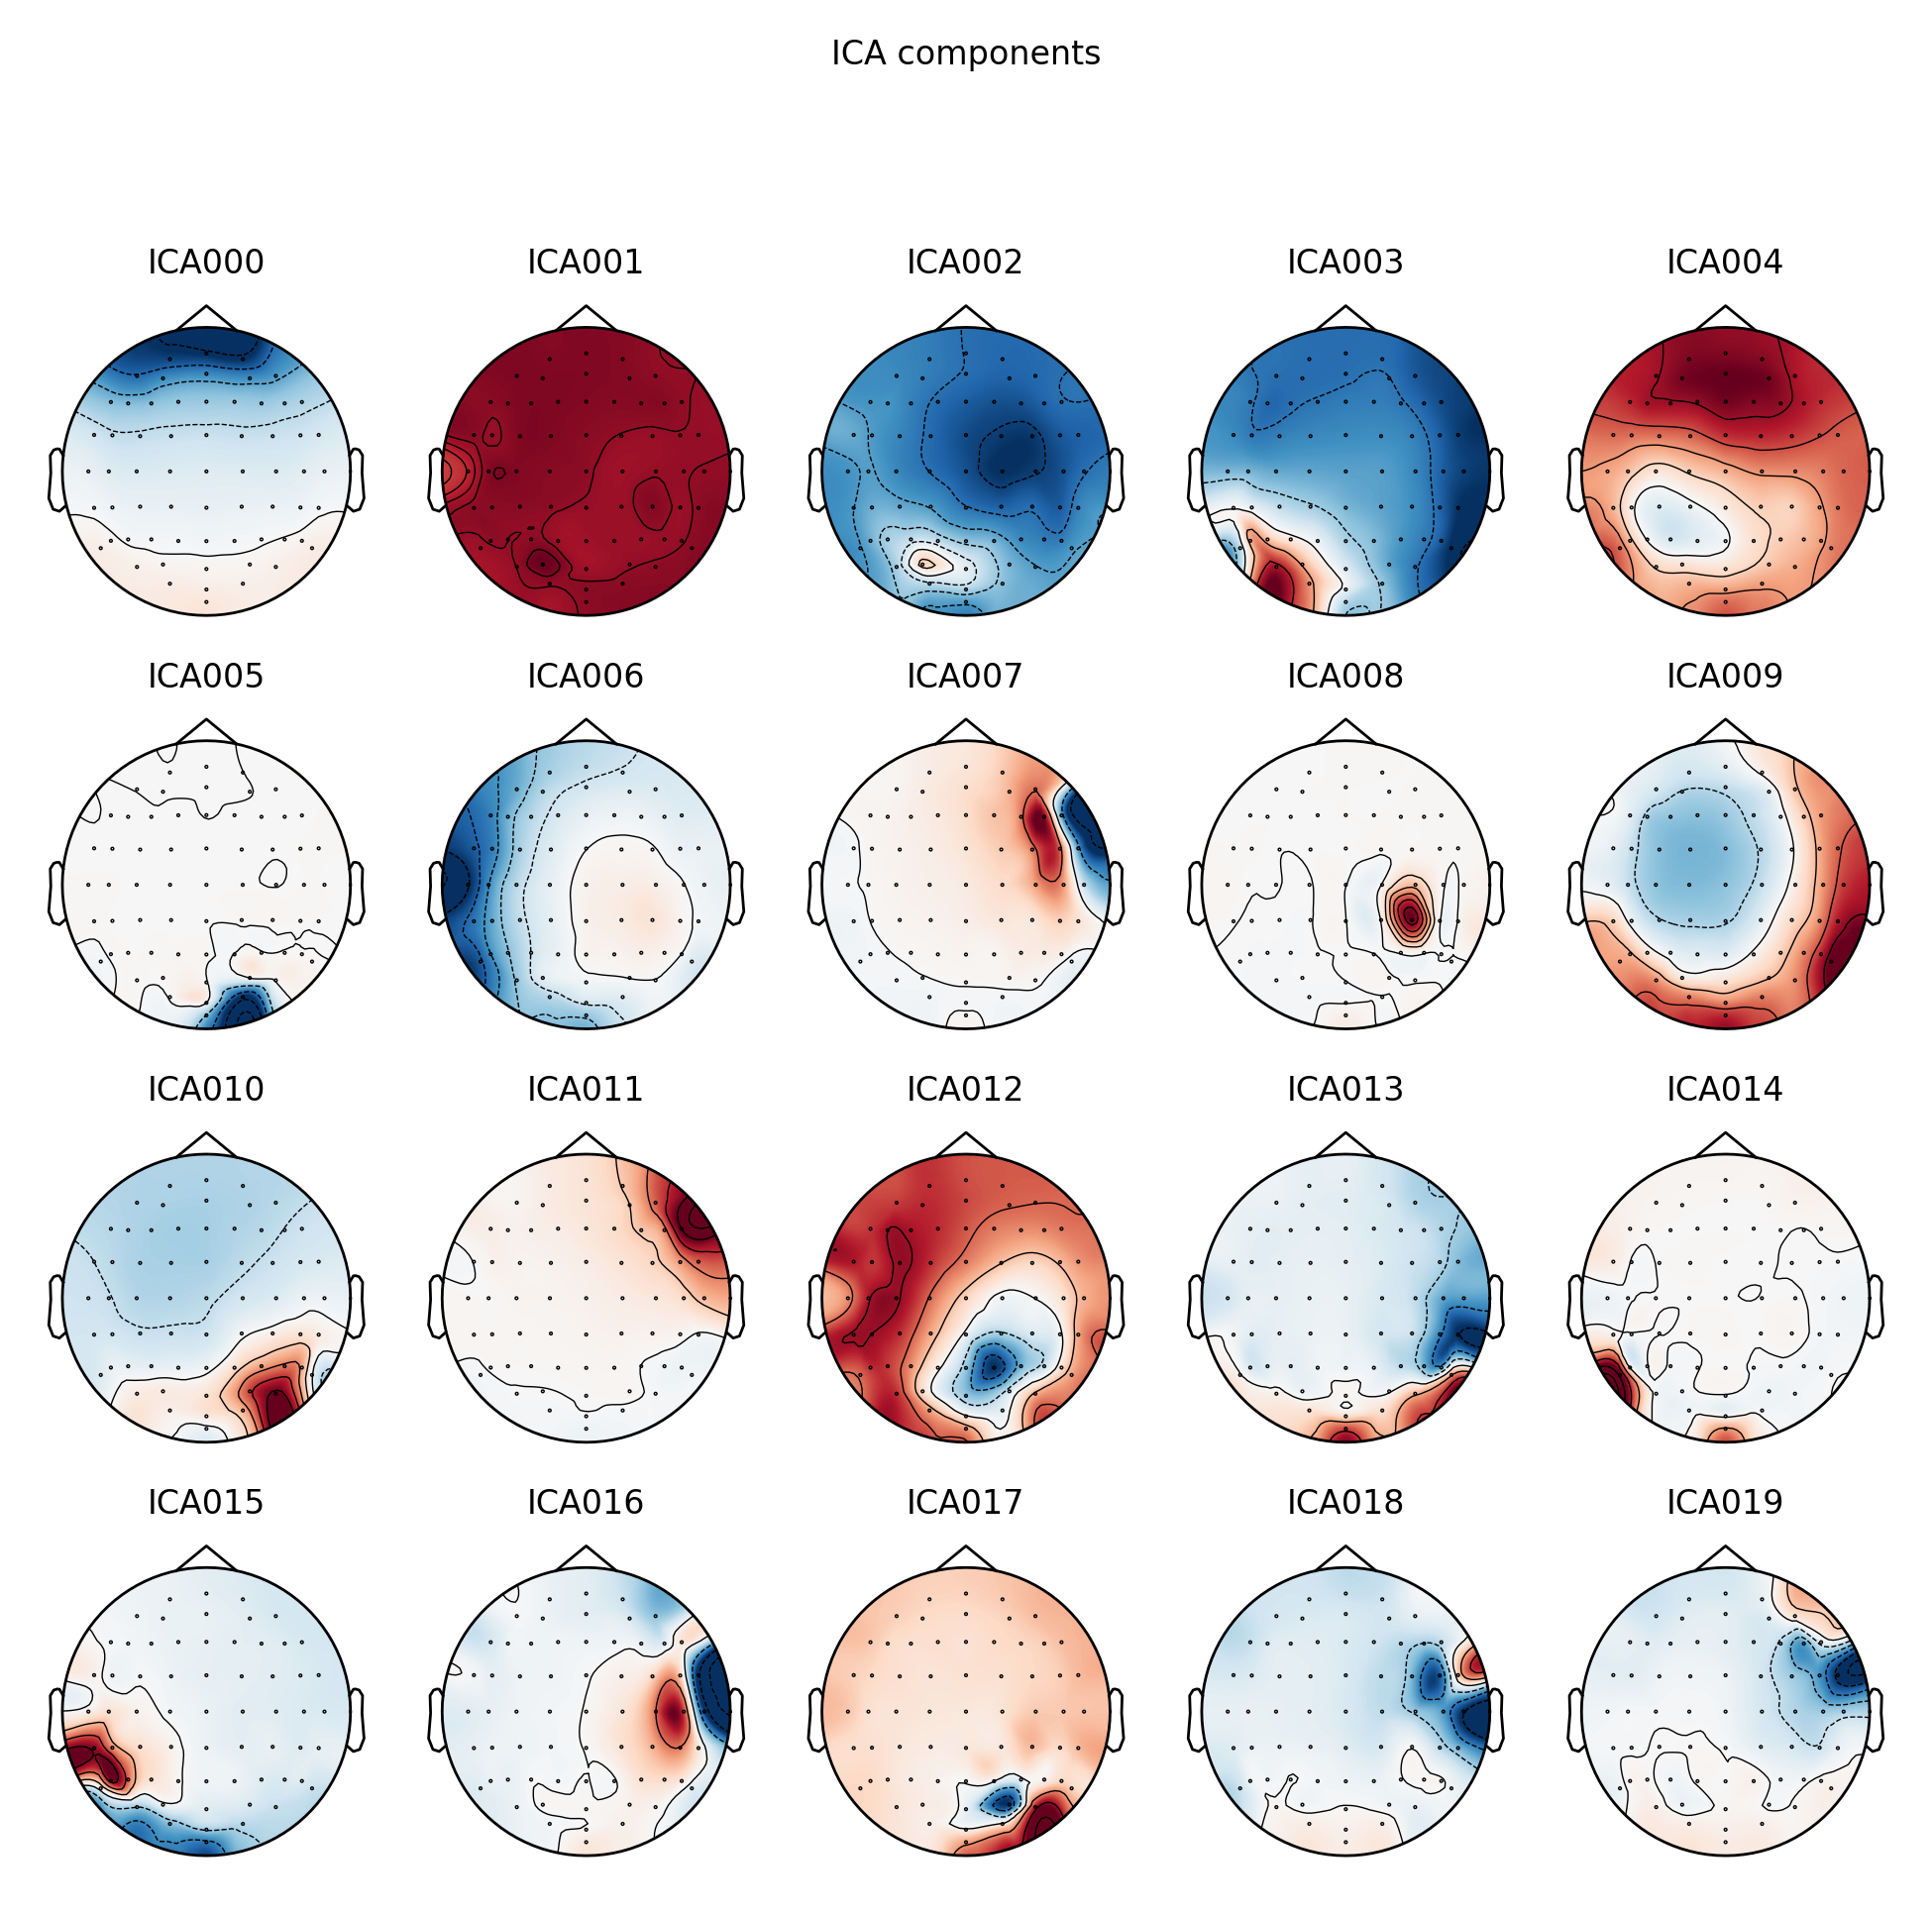

<IPython.core.display.Javascript object>


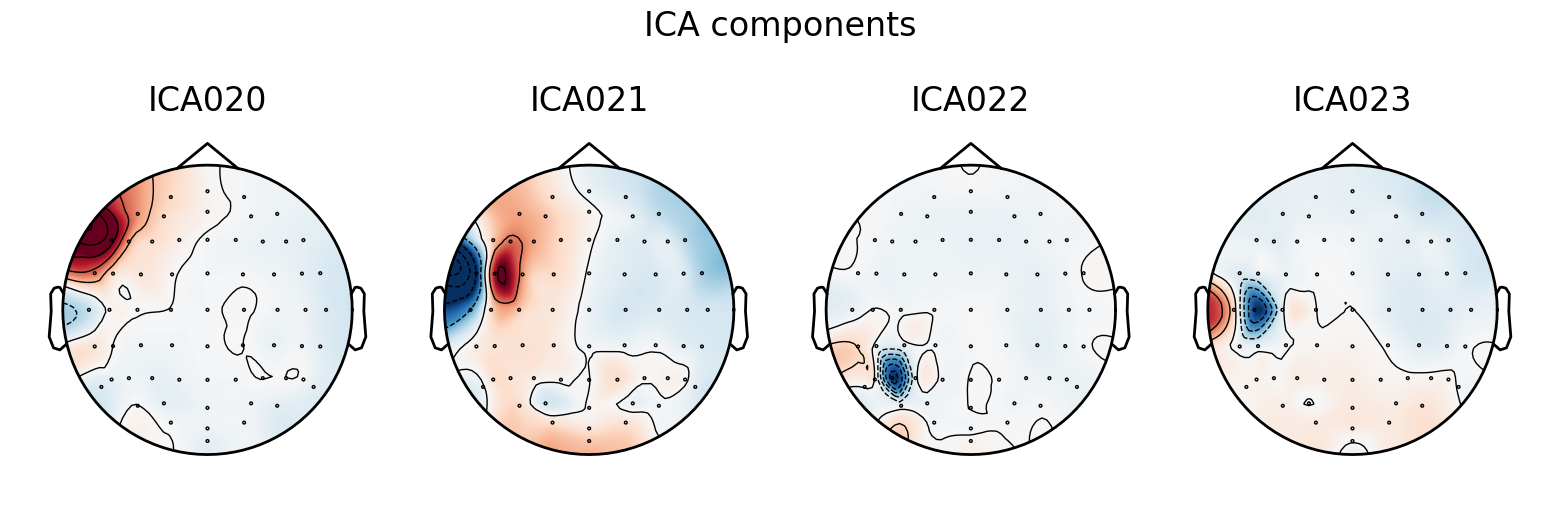

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 780x260.5 with 4 Axes>]

In [11]:
ica.plot_components()

In [187]:
ica.plot_sources(raw)

Creating RawArray with float64 data, n_channels=30, n_times=279500
    Range : 0 ... 279499 =      0.000 ...   558.998 secs
Ready.
Using pyopengl with version 3.1.6


In [14]:
ica.exclude = [0]
raw_ica = ica.apply(raw)
#raw_ica.plot();

Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


## Raw -> epochs

In [18]:
df = pd.DataFrame(e_list, columns=['timepoint', 'duration', 'stim'])

mask = (df['stim'].isin(range(1, 9))) & (df['stim'].shift(-1) == 128) | (df['stim'] == 128) & (df['stim'].shift(1).isin(range(1,9)))
correct_df = df[mask]

mne_events = correct_df.values
event_dict = {'dis_top/target_l':1,
              'dis_top/target_r':2,
              'no_dis/target_l':3,
              'no_dis/target_r':4,
              'dis_bot/target_l':5,
              'dis_bot/target_r':6,
              'dis_right/target_l':7,
              'dis_left/target_r':8,
             }



epochs = mne.Epochs(raw_ica, mne_events, event_id=event_dict, tmin=-0.2, tmax=1, baseline=(-0.2, 0), event_repeated='drop', preload=True)
epochs.set_eeg_reference(ref_channels='average');

Not setting metadata
237 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 237 events and 601 original time points ...
122 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [19]:
reject_criteria = dict(eeg=200e-6, eog=300e-6)  # 100 µV, 200 µV
epochs.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EOG : ['EXG1']
    Rejecting  epoch based on EOG : ['EXG1']
    Rejecting  epoch based on EOG : ['EXG1', 'EXG2']
    Rejecting  epoch based on EOG : ['EXG1', 'EXG2']
    Rejecting  epoch based on EOG : ['EXG1']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['AF8', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'C6', 'O2']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['P9', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EOG : ['EXG1']
    Rejecting  epoch based on EOG : ['EXG1']
    Rejecting  epoch based on EOG : ['EXG1', 'EXG2']
    Rejecting  epoch based on EOG : ['EXG1']
    Rejecting  epoch based on EOG : ['EXG1']
    Rejecting  epoch based on EOG : ['EXG1']
    Rejecting  epoch based on EOG : ['EXG1']
    Rejecting  epoch based on EOG : ['EXG1']
    Rejecting  epoch based on EEG : ['P9']
    Rejecting  epoch based on 

Number of events,66
Events,dis_bot/target_l: 7dis_bot/target_r: 5dis_left/target_r: 12dis_right/target_l: 11dis_top/target_l: 5dis_top/target_r: 9no_dis/target_l: 9no_dis/target_r: 8
Time range,-0.200 – 1.000 sec
Baseline,-0.200 – 0.000 sec


## Quality check

In [20]:
epochs.plot()

Using pyopengl with version 3.1.6


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


<IPython.core.display.Javascript object>


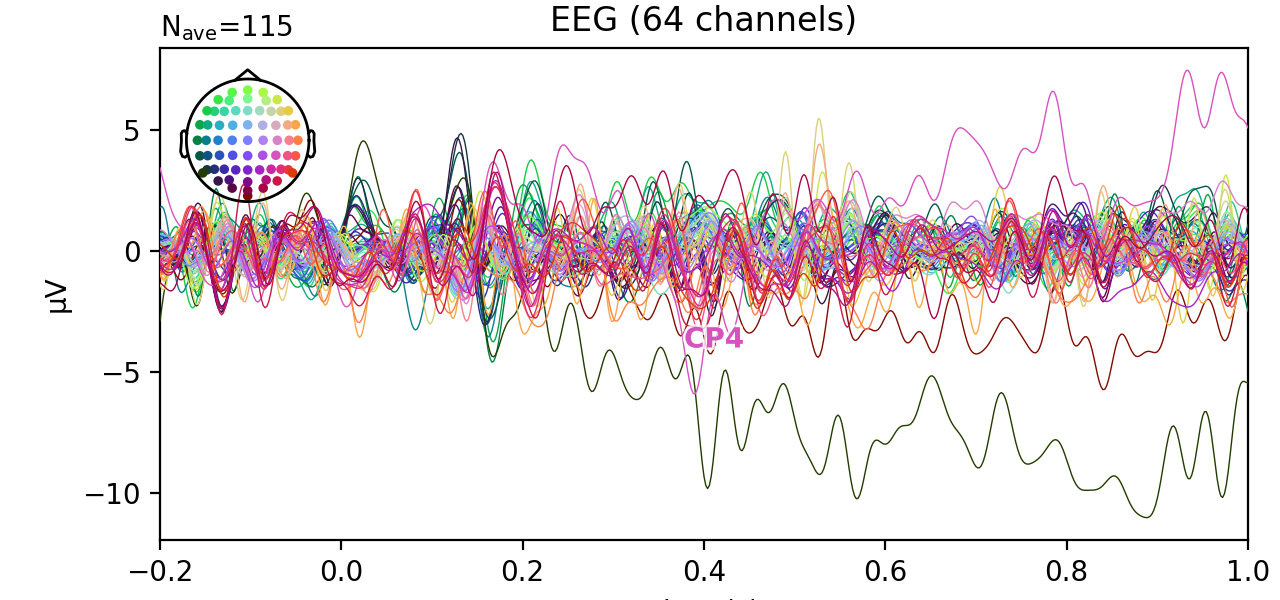

<IPython.core.display.Javascript object>


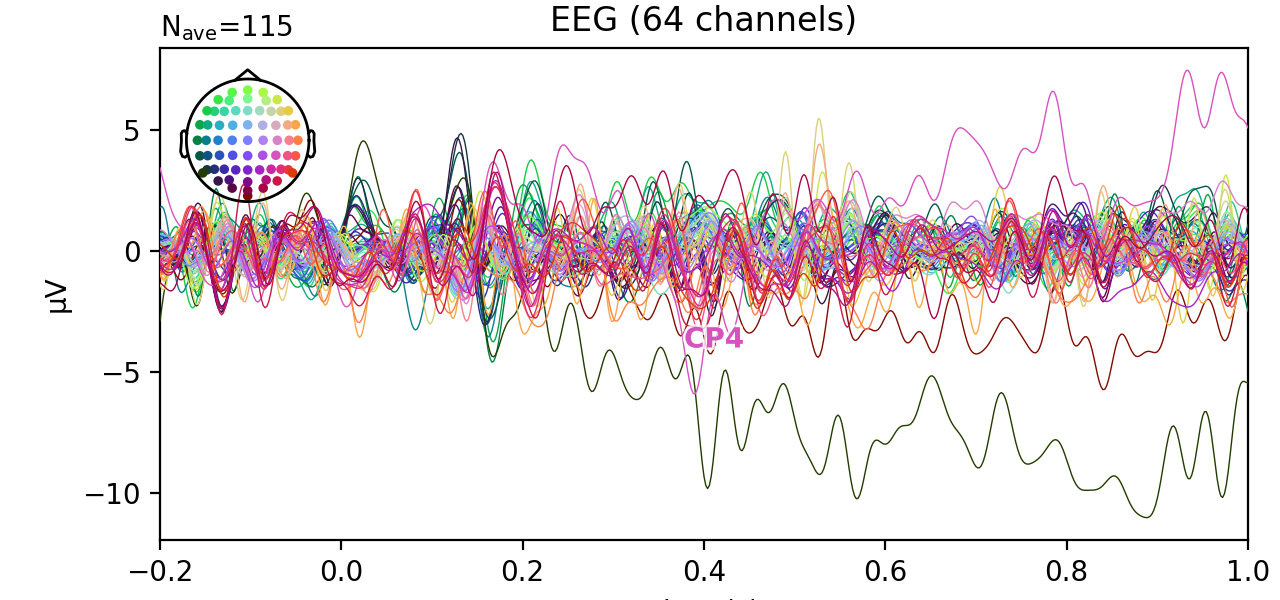

In [9]:
epochs.average().plot()

In [22]:
run = '_r1'

out_dir = '/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data'
ICA_filename = subject_id+run+'_n2pc_ICA.fif'
raw_filename = subject_id+run+'_n2pc_raw.fif'
raw_ICA_filename = subject_id+run+'_n2pc_rawICA.fif'
epochs_filename = subject_id+run+'_n2pc_epochs.fif'

ica.save(os.path.join(out_dir, 'ica', ICA_filename), overwrite=True)
raw.save(os.path.join(out_dir, raw_filename), overwrite=True)
raw_ica.save(os.path.join(out_dir, 'raw_ica', raw_ICA_filename), overwrite=True)
epochs.save(os.path.join(out_dir, 'epochs', epochs_filename), overwrite=True)


Overwriting existing file.
Writing ICA solution to /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/ica/S16_r1_n2pc_ICA.fif...
Overwriting existing file.
Writing /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/S16_r1_n2pc_raw.fif


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_25361/1939103349.py:9: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/ica/S16_r1_n2pc_ICA.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(os.path.join(out_dir, 'ica', ICA_filename), overwrite=True)


Closing /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/S16_r1_n2pc_raw.fif
[done]
Overwriting existing file.
Writing /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/raw_ica/S16_r1_n2pc_rawICA.fif


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_25361/1939103349.py:11: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/raw_ica/S16_r1_n2pc_rawICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ica.save(os.path.join(out_dir, 'raw_ica', raw_ICA_filename), overwrite=True)


Closing /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/raw_ica/S16_r1_n2pc_rawICA.fif
[done]
Overwriting existing file.


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_25361/1939103349.py:12: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/epochs/S16_r1_n2pc_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(os.path.join(out_dir, 'epochs', epochs_filename), overwrite=True)


## Concat and save 2 runs

In [23]:
subj = 'S16'
path_epochs = '/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/epochs/'

files = glob.glob(path_epochs+subject_id+'*')
files.sort()

e1 = mne.read_epochs(files[0])
e2 = mne.read_epochs(files[1])

total_epochs = mne.concatenate_epochs([e1, e2])
total_epochs.save(os.path.join(path_epochs, subj + '_n2pc_total_epochs.fif'), overwrite=True)


path_raw_ica = '/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/raw_ica/'
files = glob.glob(path_raw_ica+subject_id+'*')
files.sort()

r1 = mne.io.read_raw_fif(files[0])
r2 = mne.io.read_raw_fif(files[1])
                         
total_raw = mne.concatenate_raws([r1, r2])    
total_raw.save(os.path.join(path_raw_ica, subj + '_n2pc_total_raw_ica.fif'), overwrite=True)

Reading /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/epochs/S16_n2pc_total_epochs.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_22980/2793629944.py:7: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/epochs/S16_n2pc_total_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  e1 = mne.read_epochs(files[0])


Not setting metadata
577 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/epochs/S16_r1_n2pc_epochs.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_22980/2793629944.py:8: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/epochs/S16_r1_n2pc_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  e2 = mne.read_epochs(files[1])
/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_22980/2793629944.py:10: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  total_epochs = mne.concatenate_epochs([e1, e2])


Not setting metadata
692 matching events found
Applying baseline correction (mode: mean)
Overwriting existing file.


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_22980/2793629944.py:11: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/epochs/S16_n2pc_total_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  total_epochs.save(os.path.join(path_epochs, subj + '_n2pc_total_epochs.fif'), overwrite=True)


Opening raw data file /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/raw_ica/S16_n2pc_total_raw_ica.fif...


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_22980/2793629944.py:18: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/raw_ica/S16_n2pc_total_raw_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r1 = mne.io.read_raw_fif(files[0])


    Range : 0 ... 572999 =      0.000 ...  1145.998 secs
Ready.
Opening raw data file /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/raw_ica/S16_r1_n2pc_rawICA.fif...
    Range : 0 ... 293499 =      0.000 ...   586.998 secs
Ready.


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_22980/2793629944.py:19: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/raw_ica/S16_r1_n2pc_rawICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  r2 = mne.io.read_raw_fif(files[1])
/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_22980/2793629944.py:22: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/n2pc_out/data/raw_ica/S16_n2pc_total_raw_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  total_raw.save(os.path.join(path_raw_ica, subj + '_n2pc_total_raw

ValueError: You cannot save data to the same file. Please use a different filename.